# Monte Carlo Estimation of Pi
How do we know the value of pi? We have to compute it. One way to compute it is through random sampling. Image a 1x1 square with a cirle enscribed in it. If we randomly place dots in the sqaure, the ratio of the number of dots in the sqaure $N_s$ to the number of dots in the circle $N_c$ will estimate the ratio of the areas of the two shapes $ \frac{N_c}{N_s} = \frac{A_c}{A_s}$. Since $A_s = 1^2 = 1$ and $A_c = \pi \left(\frac{1}{2}\right)^2 = \frac{pi}{4}$, $\pi = \frac{4N_c}{N_s} = \frac{4N_c}{N}$ where $N_s = N$ since the random samples only fill within the square, so every point is within the sqaure.

In [1]:
import random
import time
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

from scipy.stats import linregress

In [2]:
N = 2**15  # total number of samples needs to be power of 2 for fast random number generation
Nc = 0

print("Total number of samples:",N)
for i in range(N):
    # Get random x and y values where bottom left corner of the sqaure is (0,0)
    rand_xval = random.getrandbits(int(np.log2(N))) / N  # returns values between 0 and 1 discretized by N
    rand_yval = random.getrandbits(int(np.log2(N))) / N  # returns values between 0 and 1 discretized by N
    # Compute radial distance [remember cirle is centered at (0.5,0.5)]
    rad_dis = np.sqrt((rand_xval-0.5)*(rand_xval-0.5) + (rand_yval-0.5)*(rand_yval-0.5))
    if (rad_dis <= 0.5):
        Nc += 1
print('pi estimation:',4*Nc/N)

Total number of samples: 32768
pi estimation: 3.1380615234375


In [3]:
# Speed up computation njit speeds up calculation from 39 miliseconds to 280 microseconds for N = 8192
@njit(fastmath=True)
def pi(N):
    Nc = 0
    for i in range(N):
        # Get random x and y values where bottom left corner of the sqaure is (0,0)
        rand_xval = random.getrandbits(int(np.log2(N))) / N  # returns values between 0 and 1 discretized by N
        rand_yval = random.getrandbits(int(np.log2(N))) / N  # returns values between 0 and 1 discretized by N
        # Compute radial distance [remember cirle is centered at (0.5,0.5)]
        rad_dis = np.sqrt((rand_xval-0.5)*(rand_xval-0.5) + (rand_yval-0.5)*(rand_yval-0.5))  # no need to take sqaure root since radius is 1
        if (rad_dis <= 0.5):
            Nc += 1
    return 4*Nc/N

In [4]:
%timeit pi(2**13)

287 µs ± 50.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
# Compute sample size N vs computation time
Ns = np.asarray([2**i for i in range(14,27)])
T = np.zeros(Ns.shape)
pi_ests = np.zeros(Ns.shape)

for i,n in enumerate(Ns):
    start = time.time()
    pi_est = pi(n)
    end = time.time()
    pi_ests[i] = pi_est
    T[i] = end-start

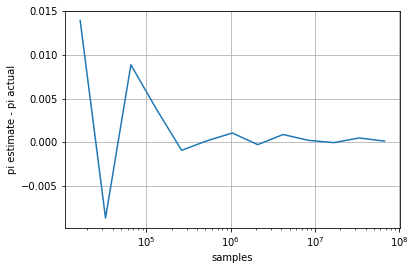

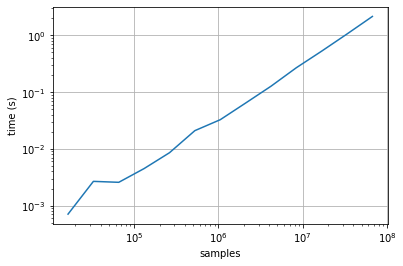

LinregressResult(slope=0.16931351413996415, intercept=-2.018721208467588, rvalue=0.7284352680192263, pvalue=0.00474527535778343, stderr=0.04801396373177443)
Largest sample: [67108864] with runtime: [2.1533649]


In [6]:
# "Residuals"
plt.plot(Ns,pi_ests-np.pi)
plt.ylabel('pi estimate - pi actual')
plt.xscale('log')
plt.xlabel('samples')
plt.grid(True)
plt.show()

# Samples vs Time
plt.plot(Ns,T)
plt.xscale('log')
plt.xlabel('samples')
plt.yscale('log')
plt.ylabel('time (s)')
plt.grid(True)
plt.show()

# Compute slope of log-log samples vs time plot
print(linregress(np.log(Ns), (T)))
print('Largest sample:',Ns[-1:],'with runtime:',T[-1:])

## Speed ups

Generating a matrix of random x's and random y's then computing the radial distances through matrix manipulation may be faster than generating individual random x and y values. Let's explore the matrix option!

#### Random number generation test:
Is using individual getrandbits() calls to generate matrix of random values faster than getting a matrix from random()?

In [7]:
# build matrix up from individual calls
N = 2**10
M = np.zeros([N,N])

@njit(fastmath=True)
def build_rand_matrix(N,M):
    for i in range(0,N):
        for j in range(0,N):
            M[i,j] = random.getrandbits(int(np.log2(N)))
    return M

In [8]:
%timeit build_rand_matrix(N,M)

21 ms ± 1.53 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
# ask for entire matrix at once from np
@njit(fastmath=True)
def rand_matrix(N):
    M = np.random.rand(N,N)
    return M

In [10]:
%timeit rand_matrix(N)

10.2 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


Sure enough the matrices win! Numpy's random.rand() function is twice as fast in the case of $N = 2^5$ and nearly twice as fast for $N = 2^{10}$. Notice that we are working NxN matrices though. This means for $N = 2^5$, we are really producing $N=2^{10}$ random numbers. In our initial computation, the total time to computer with $N = 2^{26}$ was T[-1:] which is about 2 seconds. Let's see how our random number generation time compares

In [11]:
T[-1:]

array([2.1533649])

In [12]:
N = 2**10

# FUNCTION ONLY ACCEPTS EVEN POWER OF 2 AS INPUT(e.g. N = 2**4, N = 2**6, etc.)
@njit(fastmath=True)
def pi_matrix(N):
    M = rand_matrix(np.sqrt(N))  # generate Sqrt(N)xSqrt(N) = N random numbers
    R = np.sqrt((M-0.5)*(M-0.5) + (np.transpose(M)-0.5)*(np.transpose(M)-0.5))
    Nc = np.sum(R < 0.5)
    return 4*Nc/N

In [13]:
print('pi estimate:', pi_matrix(2**13))

pi estimate: 3.1240234375


In [14]:
%timeit pi_matrix(2**13)

117 µs ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [15]:
%timeit pi(2**13)

279 µs ± 19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Pulling in at ~250 microseconds, the pi() function is SLOWER than the matrix approach by 2! Let's see how well this holds for larger matrices. At some point my laptop won't be able to lug around huge matrices and memory will start to kill the pi_matrix() performance. 

In [21]:
# See sample size N vs computation time
Ns = np.asarray([2**i for i in range(14,27)][::2])  # Need N to be a even power of 2
T = np.zeros(Ns.shape)
pi_ests = np.zeros(Ns.shape)

for i,n in enumerate(Ns):
    start = time.time()
    pi_est = pi_matrix(n)
    end = time.time()
    pi_ests[i] = pi_est
    T[i] = end-start

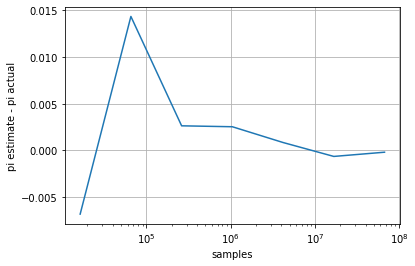

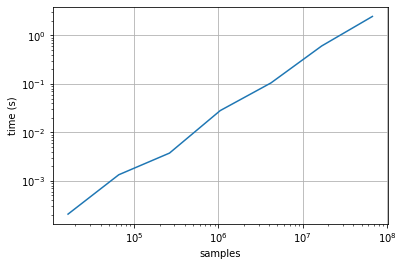

LinregressResult(slope=0.2248045300510823, intercept=-2.6568947178976874, rvalue=0.7368269723875103, pvalue=0.05887239627078897, stderr=0.09224726670581596)
Largest sample: [67108864] with runtime: [2.47115588]


In [22]:
# "Residuals"
plt.plot(Ns,pi_ests-np.pi)
plt.ylabel('pi estimate - pi actual')
plt.xscale('log')
plt.xlabel('samples')
plt.grid(True)
plt.show()

# Samples vs Time
plt.plot(Ns,T)
plt.xscale('log')
plt.xlabel('samples')
plt.yscale('log')
plt.ylabel('time (s)')
plt.grid(True)
plt.show()

# Compute slope of log-log samples vs time plot
print(linregress(np.log(Ns), (T)))
print('Largest sample:',Ns[-1:],'with runtime:',T[-1:])

Compared to the previous method and it's resulting plots, the matrix method is actually slower for the largest sample size $N$. It also has a steeper slope on the samples vs time graph. This implies the trend of longer computation for larger $N$ is only going to get **worse** for the matrix approach. The intercept is much lower than the inital method, so the matrix method is good for the **smaller** $N$s. Both have strengths and weaknesses.